In [1]:
%matplotlib inline
import numpy as np
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, datasets
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Dataset


from network import Net


%load_ext autoreload
%autoreload 2


if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

print('Imports OK')

Imports OK


In [2]:
# Global parameters

# If USE_CUDA is True, computations will be done using the GPU (may not work in all systems)
# This will make the calculations happen faster
USE_CUDA = True

DATASET_PATH = './EuroSAT_data'

BATCH_SIZE = 128 # Number of images that are used for calculating gradients at each step

NUM_EPOCHS = 20 # Number of times we will go through all the training images

LEARNING_RATE = 1e-3 # Controls the step size
MOMENTUM = 0.9 # Momentum for the gradient descent
WEIGHT_DECAY = 1e-4 # Regularization factor to reduce overfitting


print('Parameters OK')

Parameters OK


In [3]:
# Find mean and std for train.
train_dir = os.path.join(DATASET_PATH,'train')
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim=(1, 2))
    stds += torch.std(img, dim=(1, 2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.3440, 0.3801, 0.4077])
Calculated stds: tensor([0.0930, 0.0647, 0.0541])


In [4]:
# Find mean and std for test.
test_dir = os.path.join(DATASET_PATH,'test')
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in test_data:
    means += torch.mean(img, dim=(1, 2))
    stds += torch.std(img, dim=(1, 2))

means /= len(test_data)
stds /= len(test_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.3460, 0.3810, 0.4083])
Calculated stds: tensor([0.0939, 0.0652, 0.0546])


In [5]:
# Create transformations.
train_transform = transforms.Compose([
                                transforms.RandomRotation(5),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.3440, 0.3801, 0.4077], [0.0930, 0.0647, 0.0541])
                                ])
test_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.3460, 0.3810, 0.4083], [0.0939, 0.0652, 0.0546])
                                ])


In [6]:
# Create datasets and data loaders.
train_dataset = datasets.ImageFolder(root=train_dir,transform=train_transform)
train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          batch_size=BATCH_SIZE)

test_dataset = datasets.ImageFolder(root=test_dir,transform=test_transform)
test_loader =  DataLoader(test_dataset,
                          batch_size=BATCH_SIZE)


print('Dataloaders OK')
print(len(train_loader),"length of train_loader")
print(len(test_loader),"length of test_loader")

Dataloaders OK
169 length of train_loader
43 length of test_loader


In [7]:
# Create network
model = Net(n_classes=10)
#if USE_CUDA:
device = torch.device("cuda" if USE_CUDA else "cpu")
model = model.to(device)

print('Network OK')

Network OK


In [8]:
# Define criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ExponentialLR(optimizer, gamma=MOMENTUM)

In [9]:
# Helper function to organize main loop
# This function is called for training and for testing at each epoch

def run_epoch(net, optimizer, dataloader, criterion, train=True, cuda=USE_CUDA):
    epoch_total_loss = 0
    epoch_total_samples = 0
    epoch_total_correct = 0

    for sample in tqdm(dataloader):
        img = sample[0]
        label = sample[1]

        if cuda:
            img = img.to(device)
            label = label.to(device)
            
        
        result = net(img)
        loss = criterion(result,label)
        _, preds = torch.max(result, dim = 1)
        accuracy = torch.tensor(torch.sum(preds==label).item() / len(preds))

        if train: #Be aware that this function should work both for training and testing
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        
        
        with torch.no_grad():
            epoch_total_samples += 1
            epoch_total_loss += loss
            epoch_total_correct += accuracy

    return epoch_total_loss / epoch_total_samples, epoch_total_correct / epoch_total_samples

In [10]:
# Summarization of CNN model.
summary(model,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
         MaxPool2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Linear-9                  [-1, 256]       4,194,560
             ReLU-10                  [-1, 256]               0
           Linear-11                   [-1, 10]           2,570
Total params: 4,216,714
Trainable params: 4,216,714
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forw

  0%|          | 0/169 [00:00<?, ?it/s]



Running epoch 1 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.76it/s]



Epoch 1 validation results: Loss=0.6943233013153076 | Accuracy=0.7730135321617126



  1%|          | 2/169 [00:00<00:14, 11.87it/s]



Running epoch 2 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.61it/s]



Epoch 2 validation results: Loss=0.5926827192306519 | Accuracy=0.7868216633796692



  1%|          | 2/169 [00:00<00:14, 11.37it/s]



Running epoch 3 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.74it/s]



Epoch 3 validation results: Loss=0.5736287832260132 | Accuracy=0.7980862259864807



  1%|          | 2/169 [00:00<00:13, 12.03it/s]



Running epoch 4 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.70it/s]



Epoch 4 validation results: Loss=0.47595569491386414 | Accuracy=0.8375120759010315



  1%|          | 2/169 [00:00<00:13, 12.03it/s]



Running epoch 5 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.63it/s]



Epoch 5 validation results: Loss=0.41516250371932983 | Accuracy=0.8576792478561401



  1%|          | 2/169 [00:00<00:13, 12.03it/s]



Running epoch 6 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.64it/s]



Epoch 6 validation results: Loss=0.39349716901779175 | Accuracy=0.8670058250427246



  1%|          | 2/169 [00:00<00:13, 12.03it/s]



Running epoch 7 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.77it/s]



Epoch 7 validation results: Loss=0.39847466349601746 | Accuracy=0.8617368936538696



  1%|          | 2/169 [00:00<00:13, 12.00it/s]



Running epoch 8 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.68it/s]



Epoch 8 validation results: Loss=0.3391025960445404 | Accuracy=0.8813590407371521



  1%|          | 2/169 [00:00<00:13, 12.08it/s]



Running epoch 9 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.89it/s]



Epoch 9 validation results: Loss=0.33225002884864807 | Accuracy=0.8809956312179565



  1%|          | 2/169 [00:00<00:13, 12.13it/s]



Running epoch 10 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.90it/s]



Epoch 10 validation results: Loss=0.32669904828071594 | Accuracy=0.8835998177528381



  1%|          | 2/169 [00:00<00:13, 12.06it/s]



Running epoch 11 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.86it/s]



Epoch 11 validation results: Loss=0.31503692269325256 | Accuracy=0.8944404125213623



  1%|          | 2/169 [00:00<00:13, 12.18it/s]



Running epoch 12 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.88it/s]



Epoch 12 validation results: Loss=0.2700815498828888 | Accuracy=0.9073401093482971



  1%|          | 2/169 [00:00<00:13, 12.06it/s]



Running epoch 13 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.86it/s]



Epoch 13 validation results: Loss=0.28852033615112305 | Accuracy=0.9061893820762634



  1%|          | 2/169 [00:00<00:13, 12.15it/s]



Running epoch 14 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.85it/s]



Epoch 14 validation results: Loss=0.29184502363204956 | Accuracy=0.8951671719551086



  1%|          | 2/169 [00:00<00:13, 12.12it/s]



Running epoch 15 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.85it/s]



Epoch 15 validation results: Loss=0.2586457133293152 | Accuracy=0.910973846912384



  1%|          | 2/169 [00:00<00:13, 12.07it/s]



Running epoch 16 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.85it/s]



Epoch 16 validation results: Loss=0.26690834760665894 | Accuracy=0.9111555218696594



  1%|          | 2/169 [00:00<00:13, 12.13it/s]



Running epoch 17 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.88it/s]



Epoch 17 validation results: Loss=0.25182271003723145 | Accuracy=0.9120639562606812



  1%|          | 2/169 [00:00<00:13, 12.06it/s]



Running epoch 18 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.91it/s]



Epoch 18 validation results: Loss=0.24900533258914948 | Accuracy=0.9147892594337463



  1%|          | 2/169 [00:00<00:13, 12.06it/s]



Running epoch 19 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.96it/s]



Epoch 19 validation results: Loss=0.24062465131282806 | Accuracy=0.9176962375640869



  1%|          | 2/169 [00:00<00:13, 12.24it/s]



Running epoch 20 of 20...



100%|██████████| 43/43 [00:02<00:00, 15.89it/s]



Epoch 20 validation results: Loss=0.24691486358642578 | Accuracy=0.9127907156944275



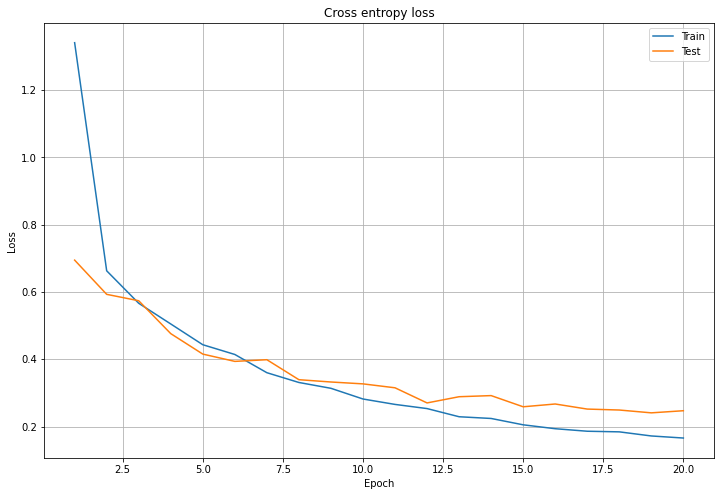

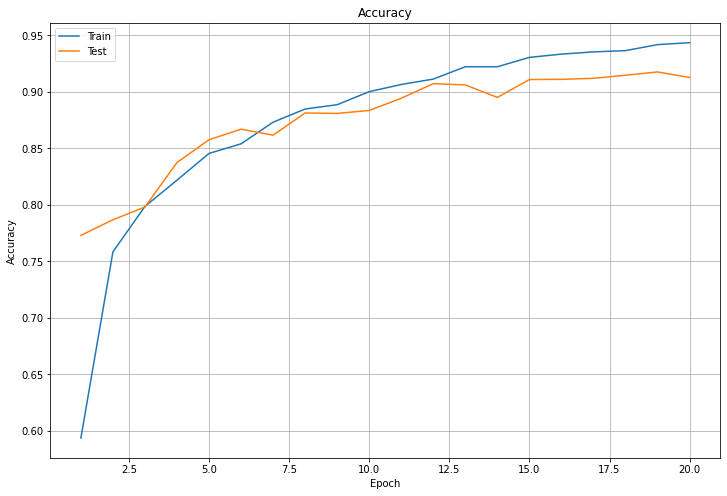

In [11]:
# Main loop

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
epochs = []

for epoch in range(1, NUM_EPOCHS+1):
    print(f'\n\nRunning epoch {epoch} of {NUM_EPOCHS}...\n')
    epochs.append(epoch)

    #-------------------------Train-------------------------
    # Set network train/test mode to 'train' in the next line
    model.train()
    
    loss, accuracy = run_epoch(model,optimizer,train_loader,criterion,train=True,cuda=USE_CUDA)
    train_loss.append(loss.cpu())
    train_accuracy.append(accuracy.cpu())
    
    # Update learning rate with scheduler in the next line
    scheduler.step()
    
    

    #-------------------------Test--------------------------
    # Set network train/test mode to 'test' in the next line
    model.eval()
    
    with torch.no_grad():
        loss, accuracy = run_epoch(model,optimizer,test_loader,criterion,train=False,cuda=USE_CUDA)
    test_loss.append(loss.cpu())
    test_accuracy.append(accuracy.cpu())
    print(f'\nEpoch {epoch} validation results: Loss={loss.cpu()} | Accuracy={accuracy.cpu()}\n')


    
    # Plot and save
    plt.figure(figsize=(12, 8), num=1)
    plt.clf()
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, test_loss, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Cross entropy loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('outputs/01-loss.pdf')

    plt.figure(figsize=(12, 8), num=2)
    plt.clf()
    plt.plot(epochs, train_accuracy, label='Train')
    plt.plot(epochs, test_accuracy, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig('outputs/02-accuracy.pdf')

In [12]:
print(f'Final train loss: {train_loss[-1]}')
print(f'Final test loss: {test_loss[-1]}')
print(f'Final train accuracy: {train_accuracy[-1]}')
print(f'Final test accuracy: {test_accuracy[-1]}')

Final train loss: 0.16579748690128326
Final test loss: 0.24691486358642578
Final train accuracy: 0.9436058402061462
Final test accuracy: 0.9127907156944275
